In [30]:
from models import *
from utils import set_seed
from data.loaders import *
from utils import *

In [31]:
user = 'ajimenez'
path_to_model = f"/home/{user}/CoSE-pytorch/wandb/run-20210223_001142-sigrco3i/files/weights_trained/epoch_150"

In [32]:
set_seed(0)
device = torch.device('cuda:0')
cose = CoSEModel('config.json', False)
cose.encoder.load_state_dict(torch.load(os.path.join(os.getcwd(), path_to_model,"encoder.pth"), map_location=device))
cose.decoder.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model ,"decoder.pth"), map_location=device))
cose.position_predictive_model.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model,"pos_pred.pth"), map_location=device))
cose.embedding_predictive_model.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model,"emb_pred.pth"), map_location=device))

<All keys matched successfully>

### train_step

In [33]:
val_path = f"/data/{user}/cose/test/"

In [34]:
cose.encoder = cose.encoder.eval()
cose.decoder = cose.decoder.eval()
cose.embedding_predictive_model = cose.embedding_predictive_model.eval()
cose.position_predictive_model = cose.position_predictive_model.eval()

In [35]:
val_path = f"/data/{user}/cose/test/"

In [36]:
batchdata = BatchCoSELoader(path = val_path,
                    filenames={"inputs_file" : "inputs_list_based.pkl",
                               "targets_file": "target_list_based.pkl"
                              }
                )

valid_loader = DataLoader(
                    dataset =batchdata,
                    batch_size = 1, #data is already in batch mode, batch_size = 1 means iterating every .get_next() returns a new batch
                )
stats_json = 'didi_wo_text-stats-origin_abs_pos.json'
stats_path = '/data/jcabrera/didi_wo_text/'
with open(os.path.join(stats_path, stats_json)) as json_file:
    stats = json.load(json_file)

mean_channel = stats['mean_channel'][:2]
std_channel = np.sqrt(stats['var_channel'][:2])
log_dir = f'/home/ajimenez/pruebas'

In [37]:
i = 0
for batch_input, batch_target in iter(valid_loader):
    if i == 1:
        break
    i+=1

In [38]:
encoder_inputs = batch_input['encoder_inputs'].squeeze(dim = 0)
num_strokes = batch_input['num_strokes'].squeeze(dim = 0)
strok_len_inputs = batch_input['seq_len'].squeeze(dim = 0)
start_coord = batch_input['start_coord'].squeeze(dim = 0).squeeze()
end_coord = batch_input['end_coord'].squeeze(dim = 0).squeeze()

enc_inputs = encoder_inputs.reshape(-1, num_strokes.max(), encoder_inputs.size(1), encoder_inputs.size(2))
seq_len = strok_len_inputs.reshape(-1, num_strokes.max())
st_coord = start_coord.reshape(-1,num_strokes.max(), start_coord.size(1))

target_ink = batch_target['t_target_ink'].squeeze(dim = 0).to(device)
target_strok_len = batch_target["seq_len"].squeeze(dim = 0)
target_pos = batch_target["start_coord"].squeeze(dim =  0)
target_strokes = batch_target["stroke"].squeeze(dim = 0)
target_num_strokes = batch_target["num_strokes"].squeeze(dim = 0)
#seq_len = target_strok_len.reshape(-1, num_strokes.max())

In [39]:
i_diagram = 0

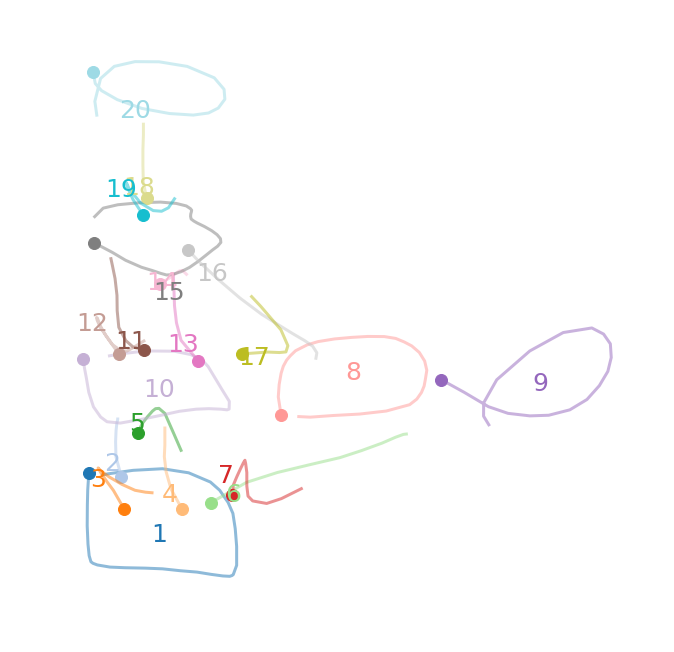

In [40]:
npfig, fig, _, _ = transform_strokes_to_image(enc_inputs[i_diagram], seq_len[i_diagram], st_coord[i_diagram], mean_channel,
                               std_channel, num_strokes=num_strokes[i_diagram], stroke_pred=None, start_coord_pred=None, output_path = log_dir, output_file = 'noutput_pruebas',  save  = True, square_figure=True, alpha=0.5, highlight_start=True)

In [41]:
encoder_inputs = encoder_inputs.to(device)
num_strokes = num_strokes.to(device)
strok_len_inputs = strok_len_inputs.to(device)
start_coord = start_coord.to(device)
end_coord = end_coord.to(device)
target_ink = target_ink.to(device)
target_strok_len = target_strok_len.to(device)
target_pos = target_pos.to(device)
target_strokes = target_strokes.to(device)
target_num_strokes = target_num_strokes.to(device)

In [42]:
comb_mask, look_ahead_mask, _ = generate_3d_mask(encoder_inputs, strok_len_inputs,device, cose.config.enc_nhead)
encoder_out = cose.encoder(encoder_inputs.permute(1,0,2), strok_len_inputs, comb_mask)

### predict_position_ar

In [43]:
embedding = encoder_out.detach().clone()
seq_len = target_strok_len.detach().clone()

In [44]:
target_strokes_list = batch_to_real_stroke_list(target_strokes, target_pos, seq_len, std_channel, mean_channel, cose.device)

In [45]:
all_strokes = np.concatenate(target_strokes_list)

In [46]:
embedding = embedding.reshape(num_strokes.size(0),-1, embedding.size(1))

In [47]:
# Auto-regressive prediction.
n_strokes = target_num_strokes[0].item()
n_strokes += 5
context_ids = 2
context_embeddings = embedding[:, :context_ids]
start_positions = np.transpose(target_pos.detach().cpu().numpy(), [1, 0, 2])

In [48]:
ar_start_pos = np.split(start_positions[:, 0:context_ids], context_ids, axis=1)

In [49]:
def draw_pred_strokes_ar_step(stroke_i, context_embeddings, ar_start_pos, mean_channel, std_channel, rel_nhead = 4, decoded_length = 50, draw = True):
    # inputs positions up unitl stroke_index
    input_pos = np.concatenate(ar_start_pos[:stroke_i], axis=1)
    
    # define seq_len and n_strokes
    n_strokes_ = context_embeddings.size(1)
    seq_len = (torch.ones_like(context_embeddings[:, 0, 0])*n_strokes_).int()
    
    # inputs to position predictive model
    pos_ar_inputs = torch.cat([context_embeddings, torch.tensor(input_pos).to(device)], dim = 2)
    
    # mask for position predictive model
    seq_mask_rel = 1 - (torch.arange(seq_len.max().item()).to(cose.device)[None, :] < seq_len[:, None]).float()
    seq_mask_rel  = seq_mask_rel.masked_fill(seq_mask_rel == 1, float('-inf')).unsqueeze(dim=1).repeat(1,seq_mask_rel.shape[1],1).repeat_interleave(rel_nhead,dim = 0)
    
    # pass to position predictive model
    pos_pred_mu, pos_pred_sigma, pos_pred_pi = cose.position_predictive_model(pos_ar_inputs, seq_len, None, seq_mask_rel)
    
    # draw sample to position predictive model
    out_pos_sample = cose.position_predictive_model.draw_sample(pos_pred_mu, pos_pred_sigma, pos_pred_pi, greedy = False)
    
    # additional inputs to embedding predictive model
    target_pos = out_pos_sample.detach().cpu().numpy()
    
    # pass to embedding predictive model with same masks
    emb_pred_mu, emb_pred_sigma, emb_pred_pi = cose.embedding_predictive_model(pos_ar_inputs, seq_len, torch.tensor(target_pos).to(device), src_mask  = seq_mask_rel)
    
    # draw sample to embedding predictive model
    emb_pred = cose.embedding_predictive_model.draw_sample(emb_pred_mu, emb_pred_sigma, emb_pred_pi, greedy = False)
    
    # add to already available embeddings and positions
    context_embeddings = torch.cat([context_embeddings, emb_pred.unsqueeze(dim = 0)], dim  =1)
    ar_start_pos.append(np.expand_dims(target_pos, axis = 0))
    
    # preparing to draw
    emb_ = context_embeddings[0]

    draw_seq_len = np.array([decoded_length]*(stroke_i + 1))

    predicted_batch_stroke = decode_sequence(cose.decoder, emb_, draw_seq_len, cose.device)

    predicted_batch_strat_pos = torch.tensor(np.transpose(np.concatenate(ar_start_pos[:stroke_i+1], axis=1), [1,0,2])).to(device)

    if draw:
        npfig, fig, _, _ = transform_strokes_to_image(predicted_batch_stroke.detach().cpu(), draw_seq_len, predicted_batch_strat_pos.detach().cpu(), mean_channel, std_channel, num_strokes=predicted_batch_stroke.shape[0], stroke_pred=None, start_coord_pred=None, output_path = log_dir, output_file = 'noutput_pruebas',  save  = True, square_figure=True, alpha=0.5, highlight_start=True)
        
    return context_embeddings, ar_start_pos, predicted_batch_stroke, predicted_batch_strat_pos, draw_seq_len

In [50]:
for stroke_i in range(context_ids, n_strokes):
    context_embeddings, ar_start_pos, predicted_batch_stroke, predicted_batch_strat_pos, draw_seq_len = draw_pred_strokes_ar_step(stroke_i, context_embeddings, ar_start_pos, mean_channel, std_channel, rel_nhead = 4, decoded_length = 50, draw = False)

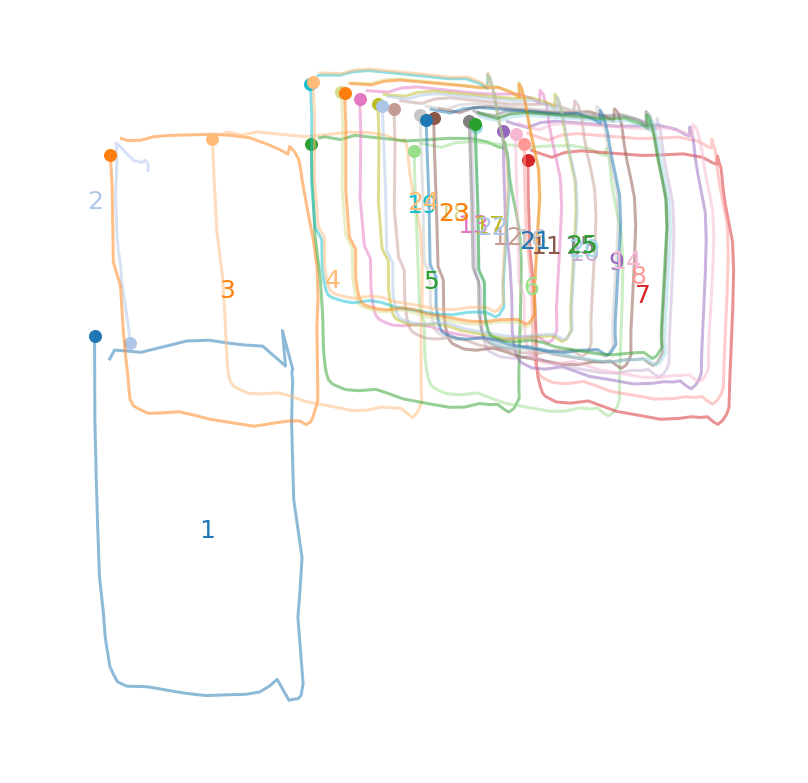

In [51]:
npfig, fig, _, _ = transform_strokes_to_image(predicted_batch_stroke.detach().cpu(), draw_seq_len, predicted_batch_strat_pos.detach().cpu(), mean_channel, std_channel, num_strokes=predicted_batch_stroke.shape[0], stroke_pred=None, start_coord_pred=None, output_path = log_dir, output_file = 'noutput_pruebas',  save  = True, square_figure=True, alpha=0.5, highlight_start=True)

In [22]:
input_pos = np.concatenate(ar_start_pos[:stroke_i], axis=1)

In [23]:
# with seq_len None
n_strokes_ = context_embeddings.size(1)
seq_len = (torch.ones_like(context_embeddings[:, 0, 0])*n_strokes_).int()

In [24]:
pos_ar_inputs = torch.cat([context_embeddings, torch.tensor(input_pos).to(device)], dim = 2)

In [25]:
seq_mask_rel = 1 - (torch.arange(seq_len.max().item()).to(cose.device)[None, :] < seq_len[:, None]).float()
seq_mask_rel  = seq_mask_rel.masked_fill(seq_mask_rel == 1, float('-inf')).unsqueeze(dim=1).repeat(1,seq_mask_rel.shape[1],1).repeat_interleave(cose.config.rel_nhead,dim = 0)

In [26]:
pos_ar_inputs.shape

torch.Size([1, 2, 10])

In [27]:
pos_pred_mu, pos_pred_sigma, pos_pred_pi = cose.position_predictive_model(pos_ar_inputs, seq_len, None, seq_mask_rel)

/home/ajimenez/CoSE-pytorch/models/gmm.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out_pi = torch.nn.functional.softmax(out_pi)


In [28]:
out_pos_sample = cose.position_predictive_model.draw_sample(pos_pred_mu, pos_pred_sigma, pos_pred_pi, greedy = False)

In [29]:
target_pos = out_pos_sample.detach().cpu().numpy()
ar_start_pos.append(np.expand_dims(target_pos, axis = 0))

In [30]:
pos_ar_inputs.shape

torch.Size([1, 2, 10])

In [31]:
emb_pred_mu, emb_pred_sigma, emb_pred_pi = cose.embedding_predictive_model(pos_ar_inputs, seq_len, torch.tensor(target_pos).to(device), src_mask  = seq_mask_rel)

In [32]:
emb_pred = cose.embedding_predictive_model.draw_sample(emb_pred_mu, emb_pred_sigma, emb_pred_pi, greedy = False)

In [33]:
context_embeddings = torch.cat([context_embeddings, emb_pred.unsqueeze(dim = 0)], dim  =1)

In [35]:
#global variable
decoded_length = 50

In [63]:
emb_ = context_embeddings[0]

seq_len = np.array([decoded_length]*(stroke_i + 1))
 
predicted_batch_stroke = decode_sequence(cose.decoder, emb_, seq_len, cose.device)

predicted_batch_strat_pos = torch.tensor(np.transpose(np.concatenate(ar_start_pos[:stroke_i+1], axis=1), [1,0,2])).to(device)

stoke_colors = None

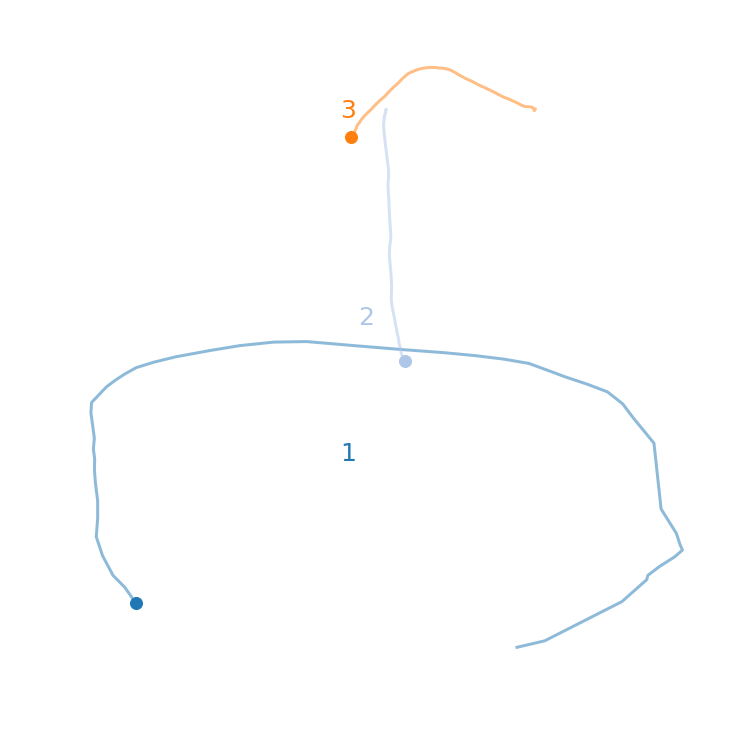

In [74]:
npfig, fig, _, _ = transform_strokes_to_image(predicted_batch_stroke.detach().cpu(), seq_len, predicted_batch_strat_pos.detach().cpu(), mean_channel,
                               std_channel, num_strokes=3, stroke_pred=None, start_coord_pred=None, output_path = log_dir, output_file = 'noutput_pruebas',  save  = True, square_figure=True, alpha=0.5, highlight_start=True)

In [64]:
pred_strokes_list = batch_to_real_stroke_list(predicted_batch_stroke, predicted_batch_strat_pos, seq_len, std_channel, mean_channel, device)

In [65]:
all_pred_strokes = np.concatenate(pred_strokes_list, axis=0)

In [66]:
pred_x_min, pred_x_max = get_min_max(all_pred_strokes[:, 0], 0.3)
pred_y_min, pred_y_max = get_min_max(all_pred_strokes[:, 1], 0.3)

In [67]:
x_min = min(x_min, pred_x_min)
x_max = max(x_max, pred_x_max)
y_min = min(y_min, pred_y_min)
y_max = max(y_max, pred_y_max)

In [ ]:
context_embeddings = tf.concat([context_embeddings, tf.expand_dims(out_["embedding_sample"], axis=0)], axis=1)
      emb_ = context_embeddings[0].numpy()

      # seq_len = target_batch["seq_len"][:stroke_i + 1]
      seq_len = np.array([self.decoded_length]*(stroke_i + 1))
      if not self.gt_len_decoding:
        seq_len = np.array([self.decoded_length]*(stroke_i + 1))
        
      predicted_batch = self.embedding_model.decode_sequence(emb_,
                                                             seq_len=seq_len)
      predicted_batch[C.INP_START_COORD] = np.transpose(np.concatenate(ar_start_pos[:stroke_i+1], axis=1), [1,0,2])

      stoke_colors = None
      if self.render_binary_colors:
        stoke_colors = ["k"]*(stroke_i + 1)
        stoke_colors[stroke_i] = self.prediction_color
      

In [13]:
embedding = encoder_out.detach().clone()
seq_len = target_strok_len.detach().clone()

In [14]:
recon_stroke = decode_sequence(cose.decoder, embedding, seq_len, cose.device)

/home/ajimenez/CoSE-pytorch/models/gmm.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out_pi = torch.nn.functional.softmax(out_pi)


In [15]:
target_strokes_list = batch_to_real_stroke_list(target_strokes, target_pos, seq_len, std_channel, mean_channel, cose.device)
recons_strokes_list = batch_to_real_stroke_list(recon_stroke, target_pos, seq_len, std_channel, mean_channel, cose.device)

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

#### TODO: Undo preprocessing function

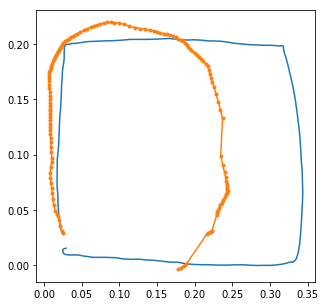

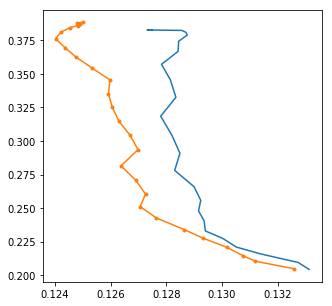

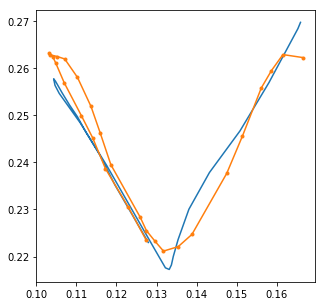

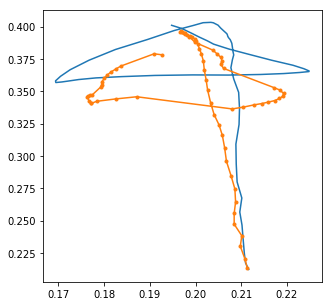

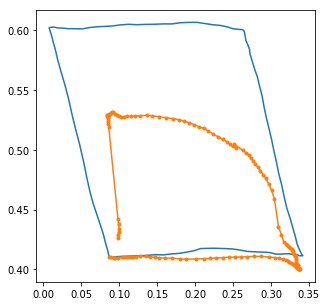

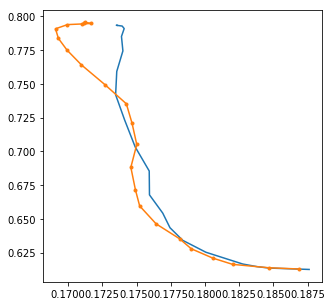

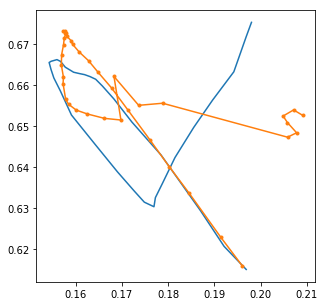

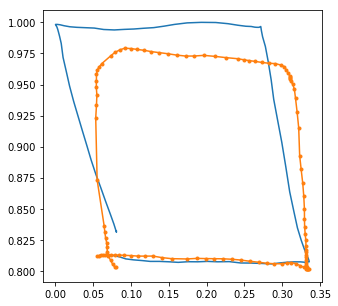

In [17]:
for i in range(recon_stroke.shape[0]):
    plt.figure(figsize = (5,5))
    plt.plot(target_strokes_list[i][:seq_len[i],0], target_strokes_list[i][:seq_len[i],1],'-')
    plt.plot(recons_strokes_list[i][:seq_len[i],0], recons_strokes_list[i][:seq_len[i],1],'.-')

### __predict_embedding_ordered_batch

In [18]:
given_strokes  = 2

In [19]:
emb_pred_mu, emb_pred_sigma, emb_pred_pi, pred_emb, target_emb = predict_embedding_ordered_batch(cose.embedding_predictive_model, cose.device, embedding, start_coord, given_strokes = given_strokes, rel_nhead = cose.config.rel_nhead)

In [21]:
nll_embedingg_loss = -1*gmm.logli_gmm_logsumexp(target_emb, emb_pred_mu, emb_pred_sigma, emb_pred_pi)[:,0].detach().cpu().numpy()

#### __decode_embedding_all_components

In [22]:
all_pred_strokes, all_pred_stroke_lens, all_emb_pi, all_emb_samples = decode_embedding_all_components([cose.embedding_predictive_model, cose.decoder],emb_pred_mu, emb_pred_sigma, emb_pred_pi, seq_len, cose.device, given_strokes)

In [23]:
n_components = all_emb_pi.shape[1]
all_target_pos = target_pos[given_strokes:].repeat(n_components,1,1)

In [24]:
pred_strokes_list = batch_to_real_stroke_list(all_pred_strokes, all_target_pos, all_pred_stroke_lens, std_channel, mean_channel, cose.device)
target_pred_strokes_list = target_strokes_list[given_strokes:]*n_components

In [25]:
results_pred = evaluate_chamfer(pred_strokes_list, target_pred_strokes_list)

In [26]:
all_comp_chamfer = np.transpose(np.reshape(np.array(results_pred), [n_components, -1]), [1, 0])
min_chamfer = np.min(all_comp_chamfer, axis=1)
min_comp_id = np.argmin(all_comp_chamfer, axis=1)

In [28]:
best_embedding_idx = torch.vstack([torch.arange(all_emb_samples.shape[0]), torch.tensor(min_comp_id)]).T

In [29]:
best_embeddings = torch.stack([all_emb_samples[index][min_comp_id[index]] for index in range(all_emb_samples.size(0))])

In [30]:
min_comp_id = np.tile(min_comp_id[:, np.newaxis], [1, n_components])
sorted_comp_id = np.argsort(all_emb_pi)

# It is in ascending order.
ordered_min_comp_id = (n_components - np.argwhere(min_comp_id == sorted_comp_id))[:, 1] ## no se entiende para que se utiliza